In [1]:
import os.path

import pandas as pd
import pydicom
import torch

In [2]:
file = pydicom.dcmread("data/11944138.dcm")

In [3]:
file.pixel_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [11]:
file.PhotometricInterpretation

'MONOCHROME2'

In [13]:
file.pixel_array.min().min()

0

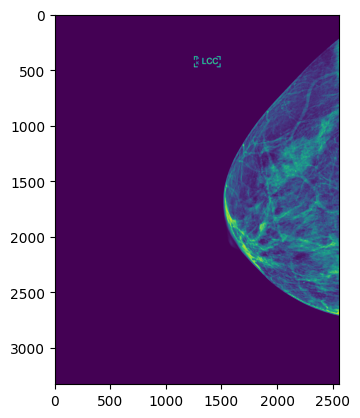

In [15]:
import matplotlib.pyplot as plt

plt.imshow(file.pixel_array)

In [9]:
import os

df = pd.read_csv("balanced_train.csv", header=0, index_col=0)
df['exists'] = df.image_id.apply(lambda x: os.path.exists(f"data/{x}.dcm"))
df = df[df.exists]
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,exists
1787,1,11937,457443056,L,CC,79.0,1,1,0,0.0,0,A,49,False,True
33408,2,45848,2102657462,L,CC,64.0,1,1,0,NaN,0,NaN,48,False,True
25798,2,37573,1344523058,L,MLO,66.0,1,1,1,NaN,0,NaN,21,False,True
35965,1,4859,416486551,L,MLO,40.0,0,0,0,2.0,0,D,49,False,True
48775,2,62576,426711161,L,CC,56.0,0,0,0,NaN,0,NaN,29,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51207,2,65198,712545807,R,MLO,72.0,1,1,1,NaN,0,NaN,48,False,True
49804,1,63706,1241091399,R,MLO,55.0,1,1,1,0.0,0,C,93,False,True
38314,1,51115,375821057,L,CC,44.0,0,0,0,1.0,0,B,190,False,True
36844,1,4953,94584715,R,CC,65.0,1,1,0,0.0,0,B,49,False,True


In [10]:
df.cancer.value_counts()

cancer
1    1155
0    1149
Name: count, dtype: int64

In [91]:
df.implant.value_counts()

implant
0    2257
1      47
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

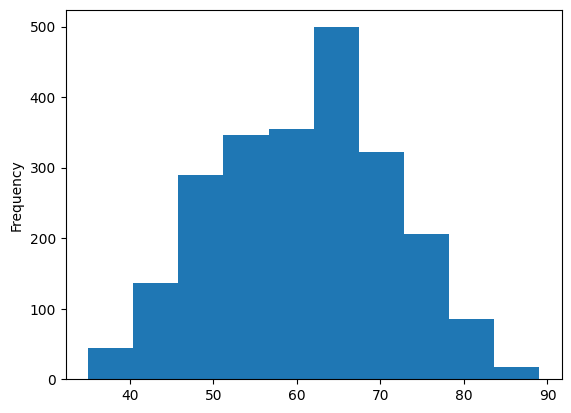

In [93]:
df.age.plot.hist()

In [48]:
from PIL import Image
import numpy as np


def min_max_scale(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)


def process_image(file_path):
    file = pydicom.dcmread(file_path)
    if file.PhotometricInterpretation == "MONOCHROME1":
        pixel_data = np.invert(file.pixel_array)
    elif file.PhotometricInterpretation == "MONOCHROME2":
        pixel_data = file.pixel_array
    else:
        return None
    img = Image.fromarray(np.uint8(min_max_scale(pixel_data)*255), mode="L").resize((512, 512))
    return min_max_scale(np.asarray(img))


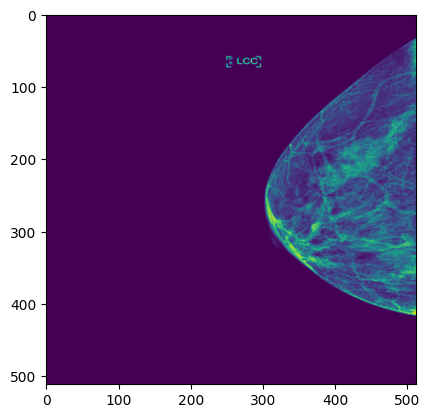

In [49]:
processed_image = process_image("data/11944138.dcm")
processed_image.shape
plt.imshow(processed_image)

In [81]:
import tqdm

processed_images = []

for image_id in tqdm.tqdm(df.image_id):
    img = process_image(f"data/{image_id}.dcm")
    processed_images.append(img)

None in processed_images

100%|██████████| 2304/2304 [45:19<00:00,  1.18s/it] 


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [83]:
any(f is None for f in processed_images)

False

In [86]:
len(processed_images)

2304

In [85]:
preprocessed_dataset = df[['cancer', 'age', 'implant']].to_numpy().reshape((-1, 3))
preprocessed_dataset.shape

(2304, 3)

In [87]:
import torch

torch.save(list(zip(torch.tensor(preprocessed_dataset),
                    torch.tensor(np.asarray(processed_images).reshape((-1, 512, 512))))),
           'preprocessed_images_with_metadata_and_target.pt')


In [90]:
import torch

torch.save(list(zip(torch.tensor(preprocessed_dataset[:50]),
                    torch.tensor(np.asarray(processed_images[:50]).reshape((-1, 512, 512))))),
           'preprocessed_images_with_metadata_and_target_small.pt')


In [79]:
data = torch.load('preprocessed_images_with_metadata_and_target.pt')

In [80]:
data

[(array([ 1., 79.,  0.]),
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         ...,
         [0.58823529, 0.55294118, 0.52941176, ..., 0.        , 0.        ,
          0.        ],
         [0.01568627, 0.01176471, 0.01176471, ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ]])),
 (array([ 1., 64.,  0.]),
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.0627451 , 0.0627451 , 0.05098039, ..., 0.        , 0.        ,
          0.        ],
         [0.17647059, 0.14117647, 0.12156863, ..., 0.        , 0.        ,
          0.        ],
         ...,
         [0.96470588, 0.96470588, 0